In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import sys
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-60000/train_labels.npy
/kaggle/input/mnist-60000/test_labels.npy
/kaggle/input/mnist-60000/train_images.npy
/kaggle/input/mnist-60000/test_images.npy
/kaggle/input/pqk-helper-files/other/default/1/boson_sampler.py
/kaggle/input/pqk-helper-files/other/default/1/model.py
/kaggle/input/pqk-helper-files/other/default/1/training.py
/kaggle/input/pqk-helper-files/other/default/1/utils.py


In [2]:
sys.path.append('/kaggle/input/pqk-helper-files/other/default/1')

In [3]:
!pip install perceval-quandela merlinquantum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.0/428.0 kB 7.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/

In [4]:
import perceval as pcvl
from perceval.components import PS, BS, Circuit
from IPython.display import SVG
from perceval.rendering.pdisplay import pdisplay

from perceval import BasicState, BackendFactory

from boson_sampler import BosonSampler
import perceval.providers.scaleway as scw

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split, random_split, TensorDataset

# import tensorflow as tf
# from tensorflow.keras import Sequential, Input, Layer
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

from model import MnistModel
# from training import fit

from utils import MNIST_partial, plot_training_metrics

import matplotlib.pyplot as plt

from utils import accuracy
from training import fit

from sklearn import datasets

import tqdm

import merlin as ML

# Device init

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else device

device = torch.device(device)
device

device(type='cuda')

In [6]:
train_images_original = np.expand_dims(np.load("/kaggle/input/mnist-60000/train_images.npy"), 1)
test_images_original = np.expand_dims(np.load("/kaggle/input/mnist-60000/test_images.npy"), 1)

# train_images_original = np.array(np.load("/content/drive/MyDrive/Colab_Notebooks/Perceval Final/encoded images/PQK_type2__k_3__train.npy"))
# test_images_original = np.array(np.load("/content/drive/MyDrive/Colab_Notebooks/Perceval Final/encoded images/PQK_type2__k_3__test.npy"))

train_labels_original = np.load("/kaggle/input/mnist-60000/train_labels.npy")
test_labels_original = np.load("/kaggle/input/mnist-60000/test_labels.npy")

In [7]:
train_images_original.shape, train_labels_original.shape

((60000, 1, 28, 28), (60000,))

In [8]:
test_idx = 12

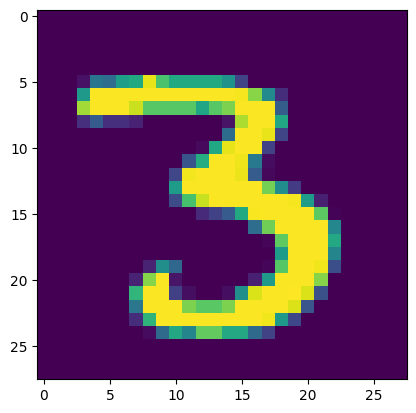

In [9]:
plt.imshow(train_images_original[test_idx, 0, :, :])

In [10]:
train_labels_original[test_idx]

3

# Dataset Definition

In [11]:
class QuantumEncodedDataset_type2(Dataset):
  def __init__(self, image_tensor, labels_tensor, num_samples, selected_channels=None):
    self.image_tensor = image_tensor
    self.labels_tensor = labels_tensor
    self.num_samples = num_samples
    self.selected_channels = selected_channels

  def __len__(self):
    return self.num_samples

  def __getitem__(self, idx):
    encoded_image_tensor = torch.from_numpy(self.image_tensor[idx]) / 255.0 # Convert to float
    # Convert the single uint8 label to a numpy array before creating the tensor
    label_tensor = torch.from_numpy(np.array(self.labels_tensor[idx]))

    if self.selected_channels is not None:
        encoded_image_tensor = encoded_image_tensor[self.selected_channels, :, :]

    return encoded_image_tensor, label_tensor

In [12]:
train_dataset = QuantumEncodedDataset_type2(
    image_tensor=train_images_original,
    labels_tensor=train_labels_original,
    num_samples=len(train_labels_original),
    selected_channels=None
)

test_dataset = QuantumEncodedDataset_type2(
    image_tensor=test_images_original,
    labels_tensor=test_labels_original,
    num_samples=len(test_labels_original),
    selected_channels=None
)

In [13]:
quantum_type_2__train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
quantum_type_2__test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Merlin Things

In [14]:
def encoding_layer(type=2, kernel_size=2):
    # assert data is not None
    if type == 1:
        modes = kernel_size ** 2
    elif type == 2:  # delayed encoding
        modes = kernel_size ** 2
        if (modes % 2) == 1:
            modes += 1
        modes //= 2

    circuit = pcvl.Circuit(modes)

    if type == 1:
        # Encoding each pixel value as a phase shift on a separate mode
        # for i, pixel in enumerate(data):
        for i in range(kernel_size**2):
            # circuit.add(i % modes, pcvl.PS(2 * np.pi * pixel))
            # circuit.add(i % modes, pcvl.PS(2 * np.pi * pcvl.P(f"px{i}")))
            circuit.add(i % modes, pcvl.PS(pcvl.P(f"px{i}")))
        # Add beam splitters in a chain to entangle modes
        for i in range(0, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        for i in range(1, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass

    elif type == 2:
        # Delayed encoding: first half of phase shifts, then BS, then remaining phase shifts
        # for i, pixel in enumerate(data):
        for i in range(kernel_size**2):
            if (i % 2) == 0:
                # circuit.add(i % modes, pcvl.PS(2 * np.pi * pixel))
                # circuit.add(i % modes, pcvl.PS(2 * np.pi * pcvl.P(f"px{i}")))
                circuit.add(i % modes, pcvl.PS(pcvl.P(f"px{i}")))
        for i in range(0, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        # for i, pixel in enumerate(data):
        for i in range(kernel_size**2):
            if (i % 2) == 1:
                # circuit.add(i % modes, pcvl.PS(2 * np.pi * pixel))
                # circuit.add(i % modes, pcvl.PS(2 * np.pi * pcvl.P(f"px{i}")))
                circuit.add(i % modes, pcvl.PS(pcvl.P(f"px{i}")))
        for i in range(1, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass

    return circuit, modes

def post_encoding(circuit, modes, depth=2):
    """Apply additional layers of beam splitters to the circuit to increase mixing (entanglement)."""
    # A permutation (here identity) can be applied between layers (placeholder, currently identity)
    perm = list(range(modes))
    circuit.add(0, pcvl.PERM(perm))
    for _ in range(depth - 1):
        for i in range(modes):
            circuit.add(i, pcvl.PS(2 * np.pi / (2 ** (_ + 1))))

        for i in range(0, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        
        for i in range(1, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        perm = list(range(modes))
        circuit.add(0, pcvl.PERM(perm))
    
    # Final layer of beam splitters
    for i in range(0, modes, 2):
        try:
            circuit.add((i, (i + 1) % modes), pcvl.BS())
        except Exception:
            pass
    for i in range(1, modes, 2):
        try:
            circuit.add((i, (i + 1) % modes), pcvl.BS())
        except Exception:
            pass

def post_encoding__trainable(circuit, modes, start_idx, depth=2):
    """Apply additional layers of beam splitters to the circuit to increase mixing (entanglement)."""
    # A permutation (here identity) can be applied between layers (placeholder, currently identity)
    perm = list(range(modes))
    circuit.add(0, pcvl.PERM(perm))
    for _ in range(depth - 1):
        for i in range(modes):
            # circuit.add(i, pcvl.PS(2 * np.pi / (2 ** (_ + 1))))
            circuit.add(i, pcvl.PS(pcvl.P(f"theta{start_idx}{_}{i}")))

        for i in range(0, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        
        for i in range(1, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        perm = list(range(modes))
        circuit.add(0, pcvl.PERM(perm))
    
    # Final layer of beam splitters
    for i in range(0, modes, 2):
        try:
            circuit.add((i, (i + 1) % modes), pcvl.BS())
        except Exception:
            pass
    for i in range(1, modes, 2):
        try:
            circuit.add((i, (i + 1) % modes), pcvl.BS())
        except Exception:
            pass


In [15]:
def generate_quantum_embedding__trainable(modes=9, depth=2, re_encoding=1, layer_global_idx=1, session=None):
    # Build the encoding circuit and apply additional mixing
    for re_encoding_idx in range(re_encoding):
        encode_circuit, modes_ret = encoding_layer(kernel_size=3)
        post_encoding__trainable(encode_circuit, modes_ret, start_idx=int(str(layer_global_idx) + str(re_encoding_idx)), depth=depth)
    
    return encode_circuit

In [16]:
class QuantumConv2D__Trainable_Type2(nn.Module):
    def __init__(self, img_height, img_width, kernel_size=(3, 3), stride=1,
                 in_channels=1, output_size_merlin=6, modes_merlin=9, depth_merlin=2, layer_global_idx=1):
        super(QuantumConv2D__Trainable_Type2, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.in_channels = in_channels

        # 1. Generate the static quantum circuit template with symbolic parameters
        # This is called only once when the model is initialized.
        # self.perceval_circuit_template = generate_quantum_embedding_template(
        #     modes=modes_merlin,
        #     depth=depth_merlin
        # )
        self.perceval_circuit = generate_quantum_embedding__trainable(
            modes=modes_merlin,
            depth=depth_merlin,
            re_encoding=2,
            layer_global_idx=layer_global_idx
        )

        # 2. Instantiate the MerLin QuantumLayer with the template circuit
        # The input_size=4 corresponds to the number of classical values you will
        # feed into the 'px' group of parameters for each patch.
        self.merlin_quantum_layer = ML.QuantumLayer(
            input_size=kernel_size[0]*kernel_size[1], # This is the number of classical values per patch you'll feed
            output_size=output_size_merlin, # Your desired output features per patch
            circuit=self.perceval_circuit, # The static template circuit
            trainable_parameters=["theta"], # MerLin will find symbolic 'theta' params in the circuit
            input_parameters=["px"], # MerLin will find symbolic 'px' params in the circuit
            input_state=[1, 0] * (modes_merlin // 2) + [0] * (modes_merlin % 2),
            output_mapping_strategy=ML.OutputMappingStrategy.LINEAR,
            device=device
        )

        # 3. Define the classical encoding layer
        # # This layer takes the 9 pixel values from a 3x3 patch and outputs 4 values
        # # as expected by your quantum layer's 'input_size=4'.
        # self.classical_encoder = nn.Linear(
        #     kernel_size[0] * kernel_size[1] * in_channels,
        #     self.merlin_quantum_layer.input_size # Ensure output matches quantum layer's input_size
        # )

        # Calculate output dimensions for reshaping later
        self.output_height = (img_height - kernel_size[0]) // stride + 1
        self.output_width = (img_width - kernel_size[1]) // stride + 1

    def forward(self, x):
        # x is the input image tensor: (batch_size, in_channels, height, width)
        # print("x is on device:", x.get_device())
        batch_size, _, img_height, img_width = x.shape

        # 1. Extract Patches using F.unfold (classical, optimized)
        # Ensure input 'x' is already float32 and normalized (e.g., to [0,1])
        patches = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride)
        # patches shape: (batch_size, kernel_size*kernel_size*in_channels, num_patches)

        # 2. Reshape patches for batch processing by the classical encoder
        num_patches_per_image = patches.shape[2]
        patches_flat = patches.permute(0, 2, 1).reshape(-1, self.kernel_size[0] * self.kernel_size[1] * self.in_channels)
        # print("device of patches_flat:", patches_flat.get_device())
        # patches_flat shape: (batch_size * num_patches, 9)

        # # 3. Apply the Classical Encoding Layer
        # # This converts the 9-pixel input to the 4-value input for the quantum layer.
        # encoded_input_for_quantum = self.classical_encoder(patches_flat)
        # # encoded_input_for_quantum shape: (batch_size * num_patches, 4)

        # 4. Apply the MerLin Quantum Layer (quantum kernel applied to all patches in batch)
        # MerLin's QuantumLayer will take this batched input and bind the values
        # to the symbolic 'px' parameters in the 'perceval_circuit_template'.

        # quantum_features_flat = self.merlin_quantum_layer(encoded_input_for_quantum)
        quantum_features_flat = self.merlin_quantum_layer(patches_flat)
        # print("device of quantum_features_flat:", quantum_features_flat.get_device())

        # quantum_features_flat shape: (batch_size * num_patches, output_size_merlin)

        # 5. Reshape the quantum features back into a 2D feature map
        quantum_feature_map = quantum_features_flat.view(
            batch_size,
            num_patches_per_image,
            self.merlin_quantum_layer.output_size
        ).permute(0, 2, 1) # (batch_size, output_size_merlin, num_patches)

        quantum_feature_map = quantum_feature_map.view(
            batch_size,
            self.merlin_quantum_layer.output_size,
            self.output_height,
            self.output_width
        )
        # print("device of quantum_feature_map:", quantum_feature_map.get_device())

        return quantum_feature_map

In [41]:
class Type2_TrainableKernel__Hybrid(nn.Module):
    def __init__(self, num_classes=10):
        super(Type2_TrainableKernel__Hybrid, self).__init__()
        # self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv1 = QuantumConv2D__Trainable_Type2(
                        img_height=28,
                        img_width=28,
                        kernel_size=(5, 5),
                        stride=1,
                        in_channels=1,
                        output_size_merlin=16, # Output features per patch from MerLin layer
                        modes_merlin=5,      # Modes in your Perceval circuit
                        depth_merlin=2,      # Depth of your post_encoding
                        layer_global_idx=1
                    )

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2__wo_pool = QuantumConv2D__Trainable_Type2(
                                img_height=26,
                                img_width=26,
                                kernel_size=(5, 5),
                                stride=1,
                                in_channels=16,
                                output_size_merlin=32, # Output features per patch from MerLin layer
                                modes_merlin=5,      # Modes in your Perceval circuit
                                depth_merlin=2,      # Depth of your post_encoding
                                layer_global_idx=2
                            )
        self.conv2__w_pool = QuantumConv2D__Trainable_Type2(
                                img_height=13,
                                img_width=13,
                                kernel_size=(5, 5),
                                stride=1,
                                in_channels=16,
                                output_size_merlin=32, # Output features per patch from MerLin layer
                                modes_merlin=5,      # Modes in your Perceval circuit
                                depth_merlin=2,      # Depth of your post_encoding
                                layer_global_idx=2
                            )

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(64*7*7, num_classes)
            
        # self.fc1__wo_pool = nn.Linear(32*22*22, 512)
        self.fc1__wo_pool = nn.Linear(16*24*24, 512)
        
        self.fc1__w_pool = nn.Linear(32*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_classes)

        self.drop1 = nn.Dropout(0.2)
        self.drop2 = nn.Dropout(0.4)

    def forward(self, x):
        # x = self.pool(self.relu(self.conv1(x)))
        # x = self.pool(self.relu(self.conv2(x)))
        # x = self.flatten(x)
        # x = self.fc(x)

        # print("device of x:", x.get_device())

        conv1_out = self.conv1(x)
        # print("device of conv1_out:", conv1_out.get_device())
        
        x = self.relu(conv1_out)

        # conv2_out = self.conv2__wo_pool(x)
        # x = self.relu(conv2_out)

        x = self.flatten(x)

        x = self.fc1__wo_pool(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.fc3(x)

        # return x, conv1_out.clone().detach(), conv2_out.clone().detach()
        return x, conv1_out.clone().detach(), conv1_out.clone().detach()
        # return x

In [42]:
path__type2_trainable_kernel_logs = "/kaggle/working/"

In [43]:
model__type2_trainable_kernel = Type2_TrainableKernel__Hybrid(num_classes=10)
model__type2_trainable_kernel

Type2_TrainableKernel__Hybrid(
  (conv1): QuantumConv2D__Trainable_Type2(
    (merlin_quantum_layer): QuantumLayer(
      (output_mapping): Linear(in_features=10, out_features=16, bias=True)
    )
  )
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2__wo_pool): QuantumConv2D__Trainable_Type2(
    (merlin_quantum_layer): QuantumLayer(
      (output_mapping): Linear(in_features=10, out_features=32, bias=True)
    )
  )
  (conv2__w_pool): QuantumConv2D__Trainable_Type2(
    (merlin_quantum_layer): QuantumLayer(
      (output_mapping): Linear(in_features=10, out_features=32, bias=True)
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=3136, out_features=10, bias=True)
  (fc1__wo_pool): Linear(in_features=9216, out_features=512, bias=True)
  (fc1__w_pool): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64

In [48]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model__type2_trainable_kernel.parameters(), lr=1e-3)

best_val_accuracy = 0.0
best_model_path_overall = "" # To store the path of the best saved model

# Create directory for saving embeddings
os.makedirs(path__type2_trainable_kernel_logs, exist_ok=True)
print(f"Embeddings will be saved to: {path__type2_trainable_kernel_logs}")

Embeddings will be saved to: /kaggle/working/


In [45]:
model = model__type2_trainable_kernel.to(device)

In [46]:
accuracies_PQK_type2__trainable_kernel_train = []
losses_PQK_type2__trainable_kernel_train = []

In [47]:
for epoch in range(10):
    # Create epoch-specific directories for embeddings
    epoch_embeddings_dir_l1 = os.path.join(path__type2_trainable_kernel_logs, f"epoch", "layer_1")
    epoch_embeddings_dir_l2 = os.path.join(path__type2_trainable_kernel_logs, f"epoch", "layer_2")
    os.makedirs(epoch_embeddings_dir_l1, exist_ok=True)
    os.makedirs(epoch_embeddings_dir_l2, exist_ok=True)

    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    for batch_idx, (images, labels) in enumerate(quantum_type_2__train_dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, conv1_embeds, conv2_embeds = model(images) # Capture embeddings here!
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total_train_predictions += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

        # --- Save Embeddings for this batch ---
        # detach() to remove from graph, cpu() to move to CPU, .numpy() to convert
        if batch_idx == 1:
            np.save(os.path.join(epoch_embeddings_dir_l1, f"batch_{batch_idx:05d}.npy"), conv1_embeds.cpu().numpy())
            np.save(os.path.join(epoch_embeddings_dir_l2, f"batch_{batch_idx:05d}.npy"), conv2_embeds.cpu().numpy())
            # The file will contain (batch_size, channels, height, width) for this batch.
            # You can also save a batch_idx-to-original-sample-index map if needed later.

    train_loss = running_loss / len(quantum_type_2__train_dataloader.dataset)
    train_accuracy = 100 * correct_train_predictions / total_train_predictions

    print("train_loss, train_accuracy:", train_loss, train_accuracy)

    accuracies_PQK_type2__trainable_kernel_train.append(train_accuracy)
    losses_PQK_type2__trainable_kernel_train.append(train_loss)

KeyboardInterrupt: 

In [ ]:
x = [i for i in range(1, 11)]

In [ ]:
plt.plot(x, accuracies_PQK_type2__trainable_kernel_train)
plt.show()

In [ ]:
plt.plot(x, losses_PQK_type2__trainable_kernel_train)
plt.show()

In [ ]:
model.eval() # Set model to evaluation mode
test_loss = 0.0
correct_test_predictions = 0
total_test_predictions = 0

with torch.no_grad(): # Disable gradient calculations for testing
    for images, labels in quantum_type_2__test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs, _, __ = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_test_predictions += labels.size(0)
        correct_test_predictions += (predicted == labels).sum().item()

test_loss /= len(quantum_type_2__test_dataloader.dataset)
test_accuracy = 100 * correct_test_predictions / total_test_predictions

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

In [ ]:
torch.save(model.state_dict(), "/kaggle/working/type2__trainable_kernel__w_o__pooling__layer1_only.pth")

# Two layers

In [ ]:
class Type2_TrainableKernel__Hybrid__2_layers(nn.Module):
    def __init__(self, num_classes=10):
        super(Type2_TrainableKernel__Hybrid__2_layers, self).__init__()
        # self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv1 = QuantumConv2D__Trainable_Type2(
                        img_height=28,
                        img_width=28,
                        kernel_size=(3, 3),
                        stride=1,
                        in_channels=1,
                        output_size_merlin=16, # Output features per patch from MerLin layer
                        modes_merlin=5,      # Modes in your Perceval circuit
                        depth_merlin=2,      # Depth of your post_encoding
                        layer_global_idx=1
                    )

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2__wo_pool = QuantumConv2D__Trainable_Type2(
                                img_height=26,
                                img_width=26,
                                kernel_size=(5, 5),
                                stride=1,
                                in_channels=16,
                                output_size_merlin=32, # Output features per patch from MerLin layer
                                modes_merlin=5,      # Modes in your Perceval circuit
                                depth_merlin=2,      # Depth of your post_encoding
                                layer_global_idx=2
                            )
        self.conv2__w_pool = QuantumConv2D__Trainable_Type2(
                                img_height=13,
                                img_width=13,
                                kernel_size=(5, 5),
                                stride=1,
                                in_channels=16,
                                output_size_merlin=32, # Output features per patch from MerLin layer
                                modes_merlin=5,      # Modes in your Perceval circuit
                                depth_merlin=2,      # Depth of your post_encoding
                                layer_global_idx=2
                            )

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(64*7*7, num_classes)
            
        self.fc1__wo_pool = nn.Linear(32*22*22, 512)
        # self.fc1__wo_pool = nn.Linear(16*24*24, 512)
        
        self.fc1__w_pool = nn.Linear(32*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_classes)

        self.drop1 = nn.Dropout(0.2)
        self.drop2 = nn.Dropout(0.4)

    def forward(self, x):
        # x = self.pool(self.relu(self.conv1(x)))
        # x = self.pool(self.relu(self.conv2(x)))
        # x = self.flatten(x)
        # x = self.fc(x)

        # print("device of x:", x.get_device())

        conv1_out = self.conv1(x)
        x = self.relu(conv1_out)

        conv2_out = self.conv2__wo_pool(x)
        x = self.relu(conv2_out)

        x = self.flatten(x)

        x = self.fc1__wo_pool(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.fc3(x)

        return x, conv1_out.clone().detach(), conv2_out.clone().detach()
        # return x, conv1_out.clone().detach(), conv1_out.clone().detach()
        # return x

In [ ]:
model__type2_trainable_kernel__2_layers = Type2_TrainableKernel__Hybrid__2_layers(num_classes=10)
model__type2_trainable_kernel__2_layers

In [ ]:
model__2_layer = model__type2_trainable_kernel__2_layers.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model__2_layer.parameters(), lr=1e-3)

best_val_accuracy = 0.0
best_model_path_overall = "" # To store the path of the best saved model

# Create directory for saving embeddings
os.makedirs(path__type2_trainable_kernel_logs, exist_ok=True)
print(f"Embeddings will be saved to: {path__type2_trainable_kernel_logs}")

In [ ]:
accuracies_PQK_type2__trainable_kernel__2_layers_train = []
losses_PQK_type2__trainable_kernel__2_layers_train = []

In [ ]:
for epoch in range(10, 20, 1):
    # Create epoch-specific directories for embeddings
    epoch_embeddings_dir_l1 = os.path.join(path__type2_trainable_kernel_logs, f"epoch", "layer_1")
    epoch_embeddings_dir_l2 = os.path.join(path__type2_trainable_kernel_logs, f"epoch", "layer_2")
    os.makedirs(epoch_embeddings_dir_l1, exist_ok=True)
    os.makedirs(epoch_embeddings_dir_l2, exist_ok=True)

    # --- Training Phase ---
    model__2_layer.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    for batch_idx, (images, labels) in enumerate(quantum_type_2__train_dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, conv1_embeds, conv2_embeds = model__2_layer(images) # Capture embeddings here!
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total_train_predictions += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

        # --- Save Embeddings for this batch ---
        # detach() to remove from graph, cpu() to move to CPU, .numpy() to convert
        if batch_idx == 1:
            np.save(os.path.join(epoch_embeddings_dir_l1, f"batch_{batch_idx:05d}.npy"), conv1_embeds.cpu().numpy())
            np.save(os.path.join(epoch_embeddings_dir_l2, f"batch_{batch_idx:05d}.npy"), conv2_embeds.cpu().numpy())
            # The file will contain (batch_size, channels, height, width) for this batch.
            # You can also save a batch_idx-to-original-sample-index map if needed later.

    train_loss = running_loss / len(quantum_type_2__train_dataloader.dataset)
    train_accuracy = 100 * correct_train_predictions / total_train_predictions

    print("train_loss, train_accuracy:", train_loss, train_accuracy)

    accuracies_PQK_type2__trainable_kernel__2_layers_train.append(train_accuracy)
    losses_PQK_type2__trainable_kernel__2_layers_train.append(train_loss)

In [ ]:
x = [i for i in range(1, 21)]

In [ ]:
plt.plot(x, accuracies_PQK_type2__trainable_kernel__2_layers_train)
plt.show()

In [ ]:
plt.plot(x, losses_PQK_type2__trainable_kernel__2_layers_train)
plt.show()

In [ ]:
model__2_layer.eval() # Set model to evaluation mode
test_loss = 0.0
correct_test_predictions = 0
total_test_predictions = 0

with torch.no_grad(): # Disable gradient calculations for testing
    for images, labels in quantum_type_2__test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs, _, __ = model__2_layer(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_test_predictions += labels.size(0)
        correct_test_predictions += (predicted == labels).sum().item()

test_loss /= len(quantum_type_2__test_dataloader.dataset)
test_accuracy = 100 * correct_test_predictions / total_test_predictions

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

In [ ]:
torch.save(model__2_layer.state_dict(), "/kaggle/working/type2__trainable_kernel__w_o__pooling__2layers.pth")

# Combined (2 parallel branches)

In [92]:
class Type2_TrainableKernel__Hybrid__2_layers__combined_parallel(nn.Module):
    def __init__(self, num_classes=10):
        super(Type2_TrainableKernel__Hybrid__2_layers__combined_parallel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=0)
        self.conv1_PQK = QuantumConv2D__Trainable_Type2(
                        img_height=28,
                        img_width=28,
                        kernel_size=(3, 3),
                        stride=1,
                        in_channels=1,
                        output_size_merlin=16, # Output features per patch from MerLin layer
                        modes_merlin=5,      # Modes in your Perceval circuit
                        depth_merlin=2,      # Depth of your post_encoding
                        layer_global_idx=1
                    )

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=0)
        self.conv2__wo_pool_PQK = QuantumConv2D__Trainable_Type2(
                                img_height=26,
                                img_width=26,
                                kernel_size=(5, 5),
                                stride=1,
                                in_channels=16,
                                output_size_merlin=32, # Output features per patch from MerLin layer
                                modes_merlin=5,      # Modes in your Perceval circuit
                                depth_merlin=2,      # Depth of your post_encoding
                                layer_global_idx=2
                            )
        self.conv2__w_pool_PQK = QuantumConv2D__Trainable_Type2(
                                img_height=13,
                                img_width=13,
                                kernel_size=(5, 5),
                                stride=1,
                                in_channels=16,
                                output_size_merlin=32, # Output features per patch from MerLin layer
                                modes_merlin=5,      # Modes in your Perceval circuit
                                depth_merlin=2,      # Depth of your post_encoding
                                layer_global_idx=2
                            )

        self.conv_combined = nn.Conv2d(64, 32, kernel_size=3, padding=1)

        self.flatten = nn.Flatten()

        # self.fc = nn.Linear(64*7*7, num_classes)
            
        self.fc1__wo_pool = nn.Linear(32*22*22, 512)
        # self.fc1__wo_pool = nn.Linear(16*24*24, 512)
        
        self.fc1__w_pool = nn.Linear(32*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_classes)

        self.drop1 = nn.Dropout(0.2)
        self.drop2 = nn.Dropout(0.4)

    def forward(self, x):
        # x = self.pool(self.relu(self.conv1(x)))
        # x = self.pool(self.relu(self.conv2(x)))
        # x = self.flatten(x)
        # x = self.fc(x)

        # print("device of x:", x.get_device())

        xc = self.relu(self.conv1(x))
        xc = self.relu(self.conv2(xc))

        conv1_out = self.conv1_PQK(x)
        x = self.relu(conv1_out)

        conv2_out = self.conv2__wo_pool_PQK(x)
        x = self.relu(conv2_out)

        x = torch.cat((x, xc), dim=1)
        x = self.conv_combined(x)

        x = self.flatten(x)

        x = self.fc1__wo_pool(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.fc3(x)

        return x, conv1_out.clone().detach(), conv2_out.clone().detach()
        # return x, conv1_out.clone().detach(), conv1_out.clone().detach()
        # return x

In [93]:
model__type2_trainable_kernel__2_layers__combined_parallel = Type2_TrainableKernel__Hybrid__2_layers__combined_parallel(num_classes=10)
model__type2_trainable_kernel__2_layers__combined_parallel

Type2_TrainableKernel__Hybrid__2_layers__combined_parallel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv1_PQK): QuantumConv2D__Trainable_Type2(
    (merlin_quantum_layer): QuantumLayer(
      (output_mapping): Linear(in_features=10, out_features=16, bias=True)
    )
  )
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2__wo_pool_PQK): QuantumConv2D__Trainable_Type2(
    (merlin_quantum_layer): QuantumLayer(
      (output_mapping): Linear(in_features=10, out_features=32, bias=True)
    )
  )
  (conv2__w_pool_PQK): QuantumConv2D__Trainable_Type2(
    (merlin_quantum_layer): QuantumLayer(
      (output_mapping): Linear(in_features=10, out_features=32, bias=True)
    )
  )
  (conv_combined): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1__wo_pool): Linear(in_features=15488, out

In [94]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model__type2_trainable_kernel__2_layers__combined_parallel.parameters(), lr=1e-5)

best_val_accuracy = 0.0
best_model_path_overall = "" # To store the path of the best saved model

# Create directory for saving embeddings
os.makedirs(path__type2_trainable_kernel_logs, exist_ok=True)
print(f"Embeddings will be saved to: {path__type2_trainable_kernel_logs}")

Embeddings will be saved to: /kaggle/working/


In [95]:
model = model__type2_trainable_kernel__2_layers__combined_parallel.to(device)

In [96]:
accuracies_PQK_type2__trainable_kernel_train = []
losses_PQK_type2__trainable_kernel_train = []

In [97]:
for epoch in range(10):
    # Create epoch-specific directories for embeddings
    epoch_embeddings_dir_l1 = os.path.join(path__type2_trainable_kernel_logs, f"epoch", "layer_1")
    epoch_embeddings_dir_l2 = os.path.join(path__type2_trainable_kernel_logs, f"epoch", "layer_2")
    os.makedirs(epoch_embeddings_dir_l1, exist_ok=True)
    os.makedirs(epoch_embeddings_dir_l2, exist_ok=True)

    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    for batch_idx, (images, labels) in enumerate(quantum_type_2__train_dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, conv1_embeds, conv2_embeds = model(images) # Capture embeddings here!
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total_train_predictions += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

        # --- Save Embeddings for this batch ---
        # detach() to remove from graph, cpu() to move to CPU, .numpy() to convert
        if batch_idx == 1:
            np.save(os.path.join(epoch_embeddings_dir_l1, f"batch_{batch_idx:05d}.npy"), conv1_embeds.cpu().numpy())
            np.save(os.path.join(epoch_embeddings_dir_l2, f"batch_{batch_idx:05d}.npy"), conv2_embeds.cpu().numpy())
            # The file will contain (batch_size, channels, height, width) for this batch.
            # You can also save a batch_idx-to-original-sample-index map if needed later.

    train_loss = running_loss / len(quantum_type_2__train_dataloader.dataset)
    train_accuracy = 100 * correct_train_predictions / total_train_predictions

    print("train_loss, train_accuracy:", train_loss, train_accuracy)

    accuracies_PQK_type2__trainable_kernel_train.append(train_accuracy)
    losses_PQK_type2__trainable_kernel_train.append(train_loss)

train_loss, train_accuracy: 0.7463703782637914 78.71166666666667
train_loss, train_accuracy: 0.4224008376320203 87.43
train_loss, train_accuracy: 0.3835895070195198 88.765
train_loss, train_accuracy: 0.3487217930217584 89.83833333333334
train_loss, train_accuracy: 0.3068857496480147 91.13333333333334
train_loss, train_accuracy: 0.2557075240582228 92.695
train_loss, train_accuracy: 0.20198633870581786 94.26166666666667
train_loss, train_accuracy: 0.161206649924318 95.38166666666666
train_loss, train_accuracy: 0.13509367093915742 96.11666666666666
train_loss, train_accuracy: 0.11831176459491254 96.58166666666666


In [98]:
x = [i for i in range(1, 11)]

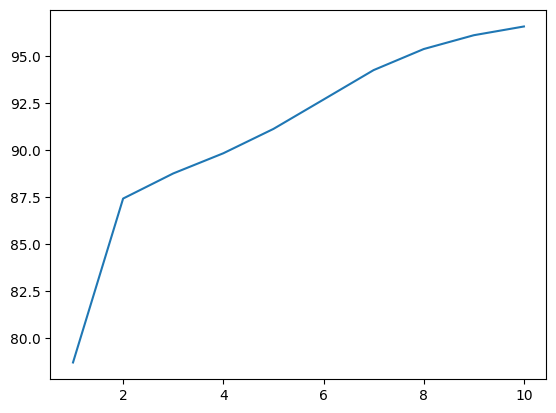

In [99]:
plt.plot(x, accuracies_PQK_type2__trainable_kernel_train)
plt.show()

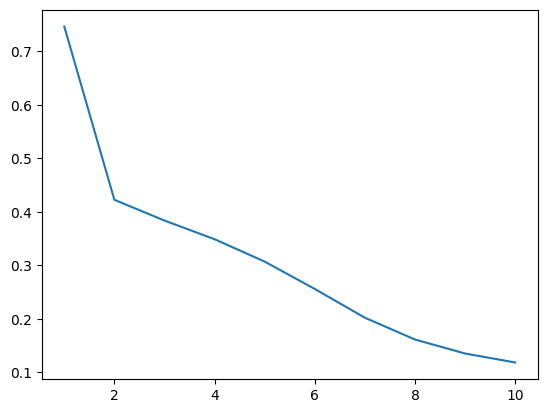

In [100]:
plt.plot(x, losses_PQK_type2__trainable_kernel_train)
plt.show()

In [101]:
model.eval() # Set model to evaluation mode
test_loss = 0.0
correct_test_predictions = 0
total_test_predictions = 0

with torch.no_grad(): # Disable gradient calculations for testing
    for images, labels in quantum_type_2__test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs, _, __ = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_test_predictions += labels.size(0)
        correct_test_predictions += (predicted == labels).sum().item()

test_loss /= len(quantum_type_2__test_dataloader.dataset)
test_accuracy = 100 * correct_test_predictions / total_test_predictions

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0727, Test Accuracy: 97.85%


In [103]:
torch.save(model.state_dict(), "/kaggle/working/type2__trainable_kernel__w_o__pooling__2layers__parallel_combined.pth")

# Displaying the circuit

In [24]:
test_perceval_circuit = generate_quantum_embedding__trainable(
    modes=5,
    depth=2,
    re_encoding=2,
    layer_global_idx=1
)

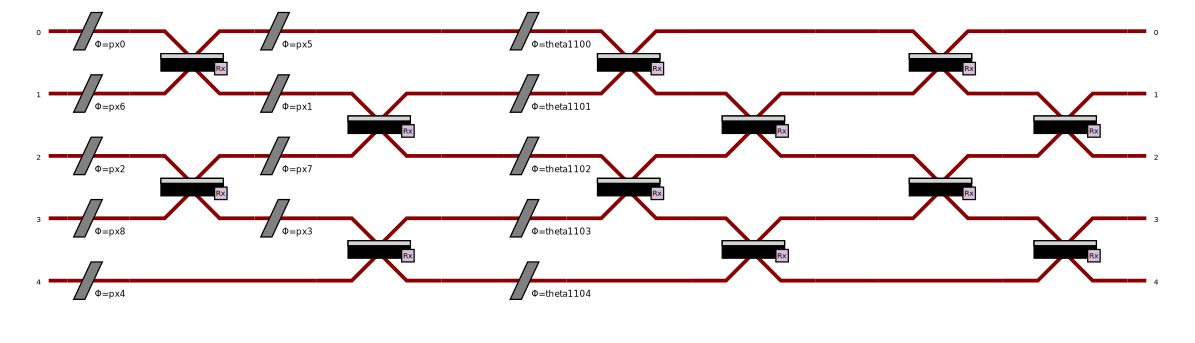

In [25]:
pcvl.pdisplay(test_perceval_circuit)